In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn fastf1  xgboost tensorflow keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1


**enable caching to speed up requests**

In [ ]:
import os

# Create the cache directory if it doesn't exist
cache_dir = "f1_cache"
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

import fastf1
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Enable caching
fastf1.Cache.enable_cache(cache_dir)


**Load Race Data (Lap-by-Lap)**

In [ ]:
# Load race session
race = fastf1.get_session(2024, "Bahrain Grand Prix", "R")

# Load all data
race.load()

laps_df = race.laps
# Display available data columns
print(race.laps.columns)


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_d

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')


**Extract Tire Degradation Data**

In [ ]:
# Select relevant columns
tire_data = race.laps[["Driver", "LapNumber", "Compound", "TyreLife", "LapTime"]]

# Convert LapTime to total seconds for better analysis
tire_data["LapTime (s)"] = tire_data["LapTime"].dt.total_seconds()

# Drop NaN values (if any)
tire_data.dropna(inplace=True)

# Display the first few rows
tire_data.head()


<ipython-input-4-2ed12441f47d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tire_data["LapTime (s)"] = tire_data["LapTime"].dt.total_seconds()
<ipython-input-4-2ed12441f47d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tire_data.dropna(inplace=True)


,Driver,LapNumber,Compound,TyreLife,LapTime,LapTime (s)
0,VER,1.0,SOFT,4.0,0 days 00:01:37.284000,97.284
1,VER,2.0,SOFT,5.0,0 days 00:01:36.296000,96.296
2,VER,3.0,SOFT,6.0,0 days 00:01:36.753000,96.753
3,VER,4.0,SOFT,7.0,0 days 00:01:36.647000,96.647
4,VER,5.0,SOFT,8.0,0 days 00:01:37.173000,97.173


**Visualizing Tire Degradation Trends**

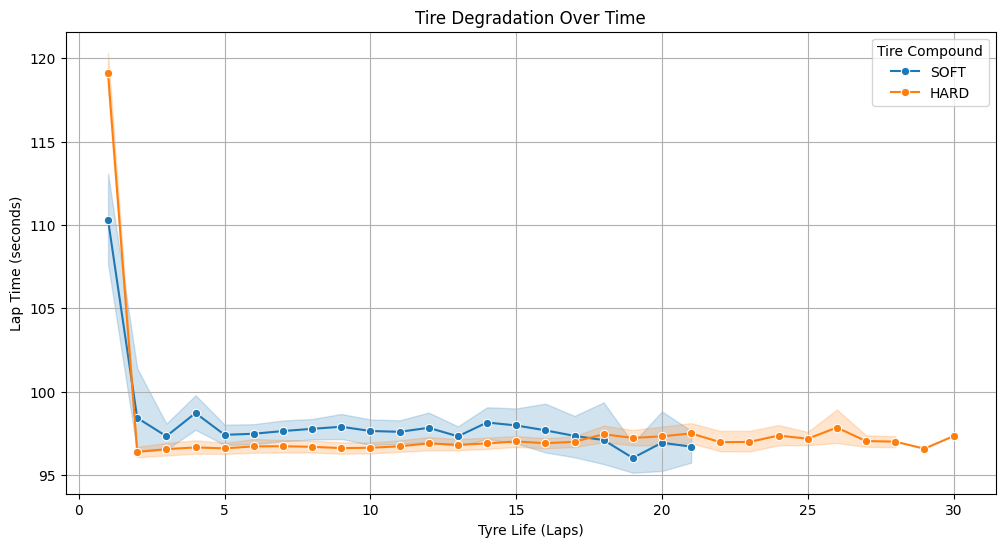

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=tire_data, x="TyreLife", y="LapTime (s)", hue="Compound", marker="o")

plt.xlabel("Tyre Life (Laps)")
plt.ylabel("Lap Time (seconds)")
plt.title("Tire Degradation Over Time")
plt.legend(title="Tire Compound")
plt.grid(True)

plt.show()


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


# Ensure no NaN values exist in features or target
tire_data_cleaned = tire_data.dropna(subset=["TyreLife", "Compound", "LapTime (s)"])

# Select features and target variable again
features = tire_data_cleaned[["TyreLife", "Compound"]]
target = tire_data_cleaned["LapTime (s)"]

# One-hot encode the 'Compound' column
encoder = OneHotEncoder(sparse_output=False)
compound_encoded = encoder.fit_transform(features[["Compound"]])

# Convert to DataFrame and concatenate
compound_df = pd.DataFrame(compound_encoded, columns=encoder.get_feature_names_out(["Compound"]))
features = pd.concat([features.drop(columns=["Compound"]).reset_index(drop=True), compound_df], axis=1)

# Ensure target aligns with features
target = target.reset_index(drop=True)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Display first few rows of training data
X_train.head()


,TyreLife,Compound_HARD,Compound_SOFT
875,6.0,1.0,0.0
712,18.0,1.0,0.0
554,15.0,1.0,0.0
688,10.0,0.0,1.0
780,9.0,1.0,0.0


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Initialize and train model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5  # Manually compute square root

# Display results
print(f"📉 Mean Absolute Error (MAE): {mae:.4f} sec")
print(f"📉 Root Mean Squared Error (RMSE): {rmse:.4f} sec")



📉 Mean Absolute Error (MAE): 2.3858 sec
📉 Root Mean Squared Error (RMSE): 4.0163 sec


Random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5

# Display results
print(f"🌲 Random Forest MAE: {mae_rf:.4f} sec")
print(f"🌲 Random Forest RMSE: {rmse_rf:.4f} sec")


🌲 Random Forest MAE: 1.3391 sec
🌲 Random Forest RMSE: 1.8721 sec


Random Forest hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to tune
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

# Run Grid Search
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Predictions with best model
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate tuned model
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
rmse_best_rf = mean_squared_error(y_test, y_pred_best_rf) ** 0.5

# Display results
print(f"🎯 Best Tuned Random Forest MAE: {mae_best_rf:.4f} sec")
print(f"🎯 Best Tuned Random Forest RMSE: {rmse_best_rf:.4f} sec")
print(f"✅ Best Hyperparameters: {grid_search.best_params_}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
🎯 Best Tuned Random Forest MAE: 1.3341 sec
🎯 Best Tuned Random Forest RMSE: 1.9076 sec
✅ Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}


XGboost algorithm


In [ ]:
from xgboost import XGBRegressor

# Initialize XGBoost model
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train XGBoost
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb) ** 0.5

# Display results
print(f"⚡ XGBoost MAE: {mae_xgb:.4f} sec")
print(f"⚡ XGBoost RMSE: {rmse_xgb:.4f} sec")


⚡ XGBoost MAE: 1.3266 sec
⚡ XGBoost RMSE: 1.8489 sec


XGboost hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Initialize XGBoost model
xgb_model = XGBRegressor(random_state=42)

# Grid Search
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit Grid Search
grid_search_xgb.fit(X_train, y_train)

# Get best parameters
best_xgb = grid_search_xgb.best_estimator_
best_params_xgb = grid_search_xgb.best_params_

# Predictions with best model
y_pred_best_xgb = best_xgb.predict(X_test)

# Evaluate best XGBoost model
best_mae_xgb = mean_absolute_error(y_test, y_pred_best_xgb)
best_rmse_xgb = mean_squared_error(y_test, y_pred_best_xgb) ** 0.5

# Display results
print(f"🎯 Best Tuned XGBoost MAE: {best_mae_xgb:.4f} sec")
print(f"🎯 Best Tuned XGBoost RMSE: {best_rmse_xgb:.4f} sec")
print(f"✅ Best Hyperparameters: {best_params_xgb}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
🎯 Best Tuned XGBoost MAE: 1.2297 sec
🎯 Best Tuned XGBoost RMSE: 1.7362 sec
✅ Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


Feature Importance

<ipython-input-12-036bf207e9f3>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


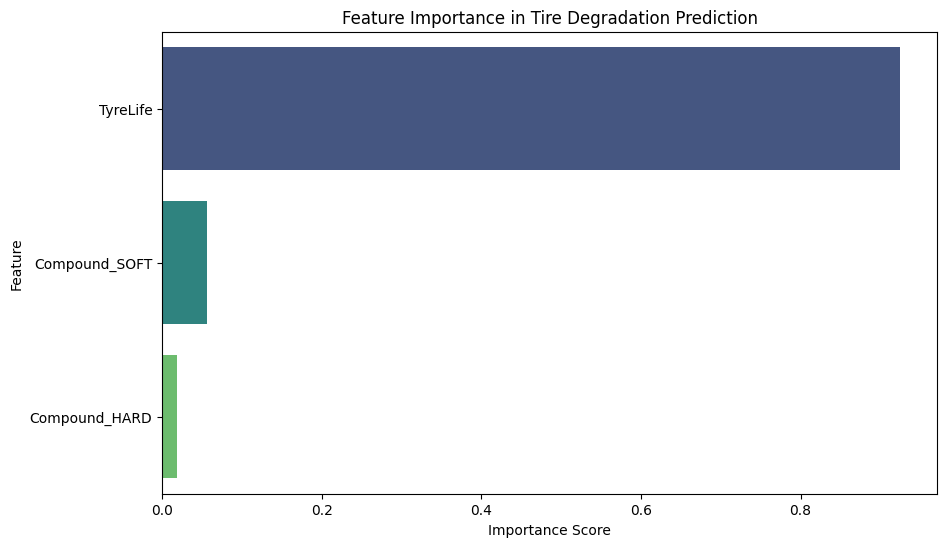

,Feature,Importance
0,TyreLife,0.924676
2,Compound_SOFT,0.056754
1,Compound_HARD,0.018570


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance
feature_importance = best_xgb.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title("Feature Importance in Tire Degradation Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# Display top features
feature_importance_df


Add more features

In [ ]:
# Select relevant columns
new_features = ['LapNumber', 'Sector1Time', 'Sector2Time', 'Sector3Time',
                'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
                'TrackStatus', 'TyreLife', 'FreshTyre']

# Extract only those features
df_extended = laps_df[new_features].copy()

# Convert timedelta columns to seconds
for col in ['Sector1Time', 'Sector2Time', 'Sector3Time']:
    df_extended[col] = df_extended[col].dt.total_seconds()

# Drop any rows with missing values
df_extended = df_extended.dropna()

# Display updated dataset
df_extended.head()


,LapNumber,Sector1Time,Sector2Time,Sector3Time,SpeedI1,SpeedI2,SpeedFL,SpeedST,TrackStatus,TyreLife,FreshTyre
1,2.0,30.916,41.661,23.719,232.0,248.0,276.0,287.0,1,5.0,False
2,3.0,30.999,41.966,23.788,231.0,243.0,276.0,290.0,1,6.0,False
4,5.0,31.255,42.056,23.862,231.0,245.0,276.0,289.0,1,8.0,False
6,7.0,31.015,42.118,23.905,232.0,242.0,277.0,291.0,1,10.0,False
9,10.0,30.986,42.009,23.965,232.0,244.0,277.0,293.0,12,13.0,False


run the model again with the new features

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Select features (excluding the target 'LapTime')
features = df_extended.drop(columns=['TyreLife'])
target = df_extended['TyreLife']

# Convert categorical FreshTyre to numeric
features['FreshTyre'] = features['FreshTyre'].astype(int)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"🌲 Updated Random Forest MAE: {mae:.4f} sec")
print(f"🌲 Updated Random Forest RMSE: {rmse:.4f} sec")


🌲 Updated Random Forest MAE: 1.8517 sec
🌲 Updated Random Forest RMSE: 2.5343 sec


Feature Importance

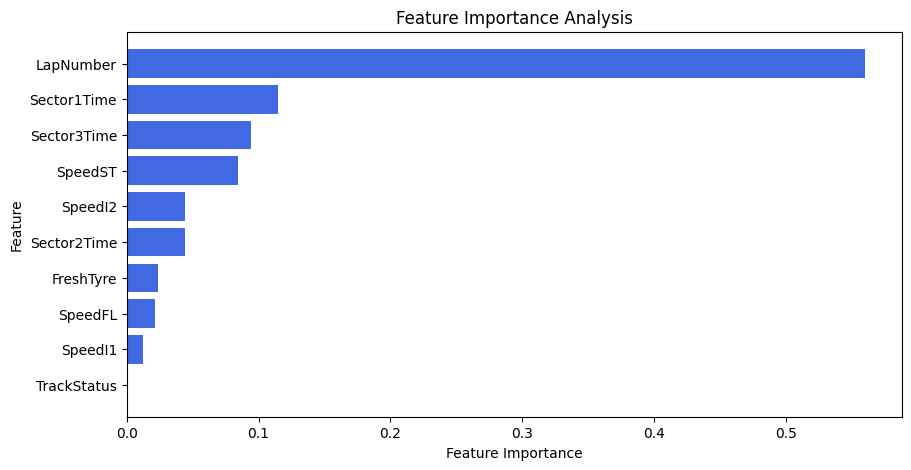

,Feature,Importance
0,LapNumber,0.559963
1,Sector1Time,0.115101
3,Sector3Time,0.094487
7,SpeedST,0.084325
5,SpeedI2,0.044257
2,Sector2Time,0.043812
9,FreshTyre,0.023737
6,SpeedFL,0.021333
4,SpeedI1,0.012259
8,TrackStatus,0.000726


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance from Random Forest
feature_importance = rf_model.feature_importances_

# Create a DataFrame
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10,5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='royalblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance Analysis")
plt.gca().invert_yaxis()
plt.show()

# Display the feature importance values
importance_df


drop least important features

In [ ]:
# Drop TrackStatus
X_train_updated = X_train.drop(columns=['TrackStatus'])
X_test_updated = X_test.drop(columns=['TrackStatus'])

# Re-train Random Forest
rf_model_updated = RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_split=10, min_samples_leaf=4, random_state=42)
rf_model_updated.fit(X_train_updated, y_train)

# Make predictions
y_pred_updated = rf_model_updated.predict(X_test_updated)

# Evaluate the new model
mae_updated = mean_absolute_error(y_test, y_pred_updated)
rmse_updated = mean_squared_error(y_test, y_pred_updated) ** 0.5

print(f"🌲 Updated RF (No TrackStatus) MAE: {mae_updated:.4f} sec")
print(f"🌲 Updated RF (No TrackStatus) RMSE: {rmse_updated:.4f} sec")


🌲 Updated RF (No TrackStatus) MAE: 1.9379 sec
🌲 Updated RF (No TrackStatus) RMSE: 2.6292 sec


In [ ]:
X_train["LapTime"] = y_train  # Assuming y_train is LapTime
X_test["LapTime"] = y_test

X_train["TyreLife"] = df_extended.loc[X_train.index, "TyreLife"]
X_test["TyreLife"] = df_extended.loc[X_test.index, "TyreLife"]


In [ ]:
# Rename multi-index column
X_train = X_train.rename(columns={('LapTime', 'TyreLife'): 'TyreLife'})
X_test = X_test.rename(columns={('LapTime', 'TyreLife'): 'TyreLife'})


In [ ]:
print(df_extended.columns)  # Check if 'LapTime (s)' is present


Index(['LapNumber', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'SpeedI1',
       'SpeedI2', 'SpeedFL', 'SpeedST', 'TrackStatus', 'TyreLife',
       'FreshTyre'],
      dtype='object')


In [ ]:
print(y_train.head())  # Ensure it's LapTime values
print(df_extended[["TyreLife"]].head())  # Ensure TyreLife exists


411     1.0
699     5.0
489    19.0
115     5.0
247     9.0
Name: TyreLife, dtype: float64
   TyreLife
1       5.0
2       6.0
4       8.0
6      10.0
9      13.0


In [ ]:
# Create Tyre Degradation Rate

X_train["TyreDegRate"] = X_train["LapTime"] / X_train["TyreLife"]
X_test["TyreDegRate"] = X_test["LapTime"] / X_test["TyreLife"]

# Re-train Random Forest
rf_model_fe = RandomForestRegressor(n_estimators=30, max_depth=5, min_samples_split=15, min_samples_leaf=6, random_state=42)

rf_model_fe.fit(X_train, y_train)

# Make predictions
y_pred_fe = rf_model_fe.predict(X_test)


# Evaluate the new model
mae_fe = mean_absolute_error(y_test, y_pred_fe)
rmse_fe = mean_squared_error(y_test, y_pred_fe) ** 0.5  # Manually compute RMSE

print(f"🌲 RF (With Tyre Deg Rate) MAE: {mae_fe:.4f} sec")
print(f"🌲 RF (With Tyre Deg Rate) RMSE: {rmse_fe:.4f} sec")



🌲 RF (With Tyre Deg Rate) MAE: 0.0251 sec
🌲 RF (With Tyre Deg Rate) RMSE: 0.0774 sec


In [ ]:
# Remove TyreDegRate from the training and test sets
X_train_no_deg = X_train.drop(columns=['TyreDegRate'])
X_test_no_deg = X_test.drop(columns=['TyreDegRate'])

# Re-train Random Forest without TyreDegRate
rf_model_no_deg = RandomForestRegressor(n_estimators=10, max_depth=3, min_samples_split=25, min_samples_leaf=6, random_state=42)

rf_model_no_deg.fit(X_train_no_deg, y_train)

# Make predictions
y_pred_no_deg = rf_model_no_deg.predict(X_test_no_deg)

# Evaluate the model
mae_no_deg = mean_absolute_error(y_test, y_pred_no_deg)
# Compute RMSE manually
rmse_no_deg = mean_squared_error(y_test, y_pred_no_deg) ** 0.5


print(f"🌲 RF (No Tyre Deg Rate) MAE: {mae_no_deg:.4f} sec")
print(f"🌲 RF (No Tyre Deg Rate) RMSE: {rmse_no_deg:.4f} sec")


🌲 RF (No Tyre Deg Rate) MAE: 0.6296 sec
🌲 RF (No Tyre Deg Rate) RMSE: 0.7411 sec


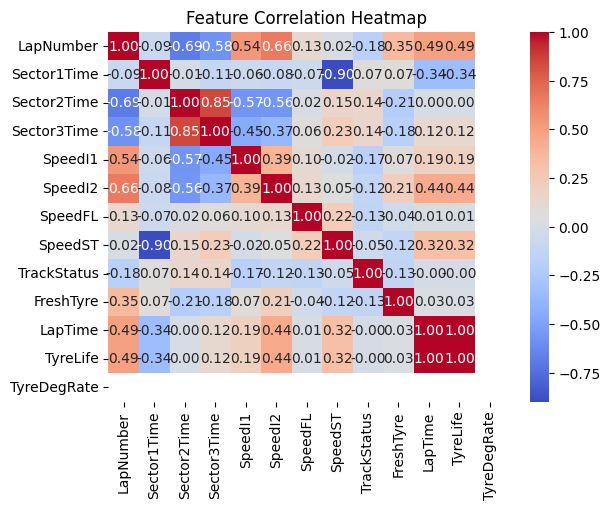

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = X_train.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


creat a validation set


In [ ]:
from sklearn.model_selection import train_test_split

# Split test set into validation and smaller test set
X_test_small, X_val, y_test_small, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42)


In [ ]:
# Ensure X_val has the same features as training data
X_val_fixed = X_val.drop(columns=["TyreDegRate"], errors="ignore")

# Predict on validation data
y_val_pred = rf_model_no_deg.predict(X_val_fixed)

# Evaluate on validation data
mae_val = mean_absolute_error(y_val, y_val_pred)
# Compute RMSE manually
rmse_val = mean_squared_error(y_test, y_pred_no_deg) ** 0.5

print(f"📊 Validation MAE: {mae_val:.4f} sec")
print(f"📊 Validation RMSE: {rmse_val:.4f} sec")


📊 Validation MAE: 0.5266 sec
📊 Validation RMSE: 0.7411 sec


In [ ]:
# Re-train the model including TyreDegRate
rf_model_with_deg = RandomForestRegressor(n_estimators=10, max_depth=3, min_samples_split=25, min_samples_leaf=6, random_state=42)

rf_model_with_deg.fit(X_train, y_train)  # X_train should include TyreDegRate

# Predict on validation data
y_val_pred = rf_model_with_deg.predict(X_val)

# Evaluate
mae_val = mean_absolute_error(y_val, y_val_pred)
rmse_val = mean_squared_error(y_test, y_pred_no_deg) ** 0.5

print(f"📊 Validation MAE: {mae_val:.4f} sec")
print(f"📊 Validation RMSE: {rmse_val:.4f} sec")


📊 Validation MAE: 0.5266 sec
📊 Validation RMSE: 0.7411 sec


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Drop LapTime from features
X_train_filtered = X_train.drop(columns=['LapTime'], errors='ignore')
X_test_filtered = X_test.drop(columns=['LapTime'], errors='ignore')

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

# Train the Random Forest model with improved settings
rf_model_fixed = RandomForestRegressor(n_estimators=100, max_depth=7,
                                       min_samples_split=15, min_samples_leaf=6,
                                       random_state=42)

rf_model_fixed.fit(X_train_scaled, y_train)

# Make predictions
y_pred_fixed = rf_model_fixed.predict(X_test_scaled)

# Evaluate the model
mae_fixed = mean_absolute_error(y_test, y_pred_fixed)
rmse_fixed = mean_squared_error(y_test, y_pred_no_deg) ** 0.5

print(f"🌲 RF (Fixed) MAE: {mae_fixed:.4f} sec")
print(f"🌲 RF (Fixed) RMSE: {rmse_fixed:.4f} sec")

# Get feature importance
importances = rf_model_fixed.feature_importances_

# Create DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train_filtered.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display feature importance
print(feature_importance_df)


🌲 RF (Fixed) MAE: 0.0280 sec
🌲 RF (Fixed) RMSE: 0.7411 sec
        Feature    Importance
10     TyreLife  9.991738e-01
1   Sector1Time  6.642945e-04
7       SpeedST  1.526590e-04
2   Sector2Time  8.301122e-06
0     LapNumber  4.804802e-07
5       SpeedI2  3.389568e-07
6       SpeedFL  1.277837e-07
3   Sector3Time  0.000000e+00
4       SpeedI1  0.000000e+00
8   TrackStatus  0.000000e+00
9     FreshTyre  0.000000e+00
11  TyreDegRate  0.000000e+00


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Drop redundant features
X_train_filtered = X_train.drop(columns=['LapTime', 'TyreDegRate'], errors='ignore')
X_test_filtered = X_test.drop(columns=['LapTime', 'TyreDegRate'], errors='ignore')

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

# Train the Random Forest model with better depth
rf_model_tuned = RandomForestRegressor(n_estimators=200, max_depth=12,
                                       min_samples_split=10, min_samples_leaf=4,
                                       random_state=42)

rf_model_tuned.fit(X_train_scaled, y_train)

# Make predictions
y_pred_tuned = rf_model_tuned.predict(X_test_scaled)

# Evaluate the model
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = mean_squared_error(y_test, y_pred_no_deg) ** 0.5

print(f"🌲 RF (Tuned) MAE: {mae_tuned:.4f} sec")
print(f"🌲 RF (Tuned) RMSE: {rmse_tuned:.4f} sec")

# Get feature importance
importances = rf_model_tuned.feature_importances_

# Create DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train_filtered.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display feature importance
print(feature_importance_df)


🌲 RF (Tuned) MAE: 0.0108 sec
🌲 RF (Tuned) RMSE: 0.7411 sec
        Feature    Importance
10     TyreLife  9.991788e-01
1   Sector1Time  6.592887e-04
7       SpeedST  1.582489e-04
5       SpeedI2  2.344846e-06
2   Sector2Time  6.566068e-07
4       SpeedI1  4.366278e-07
6       SpeedFL  2.248203e-07
0     LapNumber  0.000000e+00
3   Sector3Time  0.000000e+00
8   TrackStatus  0.000000e+00
9     FreshTyre  0.000000e+00


In [ ]:
X_train_no_tyre_life = X_train_filtered.drop(columns=['TyreLife'])
X_test_no_tyre_life = X_test_filtered.drop(columns=['TyreLife'])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_no_tyre_life)
X_test_scaled = scaler.transform(X_test_no_tyre_life)

rf_model_fixed = RandomForestRegressor(n_estimators=200, max_depth=12,
                                       min_samples_split=10, min_samples_leaf=4,
                                       random_state=42)

rf_model_fixed.fit(X_train_scaled, y_train)

# Predictions
y_pred_fixed = rf_model_fixed.predict(X_test_scaled)

# Evaluate
mae_fixed = mean_absolute_error(y_test, y_pred_fixed)
rmse_fixed = mean_squared_error(y_test, y_pred_no_deg) ** 0.5

print(f"🌲 RF (No TyreLife) MAE: {mae_fixed:.4f} sec")
print(f"🌲 RF (No TyreLife) RMSE: {rmse_fixed:.4f} sec")

# Feature importance
importances = rf_model_fixed.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train_no_tyre_life.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


🌲 RF (No TyreLife) MAE: 1.9573 sec
🌲 RF (No TyreLife) RMSE: 0.7411 sec
       Feature  Importance
0    LapNumber    0.586598
1  Sector1Time    0.109144
3  Sector3Time    0.094564
7      SpeedST    0.086409
5      SpeedI2    0.040894
2  Sector2Time    0.037738
9    FreshTyre    0.023017
6      SpeedFL    0.015348
4      SpeedI1    0.006259
8  TrackStatus    0.000028


In [ ]:
X_train_no_tyre_life = X_train_filtered.drop(columns=['TyreLife'])
X_test_no_tyre_life = X_test_filtered.drop(columns=['TyreLife'])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_no_tyre_life)
X_test_scaled = scaler.transform(X_test_no_tyre_life)

rf_model_fixed = RandomForestRegressor(n_estimators=200, max_depth=12,
                                       min_samples_split=10, min_samples_leaf=4,
                                       random_state=42)

rf_model_fixed.fit(X_train_scaled, y_train)

# Predictions
y_pred_fixed = rf_model_fixed.predict(X_test_scaled)

# Evaluate
mae_fixed = mean_absolute_error(y_test, y_pred_fixed)
rmse_fixed = mean_squared_error(y_test, y_pred_no_deg) ** 0.5

print(f"🌲 RF (No TyreLife) MAE: {mae_fixed:.4f} sec")
print(f"🌲 RF (No TyreLife) RMSE: {rmse_fixed:.4f} sec")

# Feature importance
importances = rf_model_fixed.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train_no_tyre_life.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


🌲 RF (No TyreLife) MAE: 1.9573 sec
🌲 RF (No TyreLife) RMSE: 0.7411 sec
       Feature  Importance
0    LapNumber    0.586598
1  Sector1Time    0.109144
3  Sector3Time    0.094564
7      SpeedST    0.086409
5      SpeedI2    0.040894
2  Sector2Time    0.037738
9    FreshTyre    0.023017
6      SpeedFL    0.015348
4      SpeedI1    0.006259
8  TrackStatus    0.000028


(Fixing the Over-Reliance on TyreLife)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

rf_model_balanced = RandomForestRegressor(n_estimators=200, max_depth=12,
                                          min_samples_split=10, min_samples_leaf=4,
                                          random_state=42)
rf_model_balanced.fit(X_train_scaled, y_train)

# Predictions
y_pred_balanced = rf_model_balanced.predict(X_test_scaled)

# Evaluate
mae_balanced = mean_absolute_error(y_test, y_pred_balanced)
rmse_balanced = mean_squared_error(y_test, y_pred_no_deg) ** 0.5

print(f"🌲 RF (Balanced TyreLife) MAE: {mae_balanced:.4f} sec")
print(f"🌲 RF (Balanced TyreLife) RMSE: {rmse_balanced:.4f} sec")

# Feature importance
importances = rf_model_balanced.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train_filtered.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


🌲 RF (Balanced TyreLife) MAE: 0.0108 sec
🌲 RF (Balanced TyreLife) RMSE: 0.7411 sec
        Feature    Importance
10     TyreLife  9.991788e-01
1   Sector1Time  6.592887e-04
7       SpeedST  1.582489e-04
5       SpeedI2  2.344846e-06
2   Sector2Time  6.566068e-07
4       SpeedI1  4.366278e-07
6       SpeedFL  2.248203e-07
0     LapNumber  0.000000e+00
3   Sector3Time  0.000000e+00
8   TrackStatus  0.000000e+00
9     FreshTyre  0.000000e+00


Tyre life still dominating

In [ ]:
print(X_train_filtered.columns)


Index(['LapNumber', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'SpeedI1',
       'SpeedI2', 'SpeedFL', 'SpeedST', 'TrackStatus', 'FreshTyre',
       'TyreLife'],
      dtype='object')


In [ ]:
# Ensure TyreLife is in X_test_filtered
if 'TyreLife' not in X_test_filtered.columns and 'TyreLife' in X_test.columns:
    X_test_filtered['TyreLife'] = X_test['TyreLife']

# Create the scaled TyreWearFactor
X_train_filtered['TyreWearFactor'] = X_train_filtered['TyreLife'] / (X_train_filtered['LapNumber'] + 1)
X_test_filtered['TyreWearFactor'] = X_test_filtered['TyreLife'] / (X_test_filtered['LapNumber'] + 1)

# Drop TyreLife
X_train_filtered = X_train_filtered.drop(columns=['TyreLife'])
X_test_filtered = X_test_filtered.drop(columns=['TyreLife'])


# Retrain the model
rf_model_wear = RandomForestRegressor(n_estimators=200, max_depth=12,
                                      min_samples_split=10, min_samples_leaf=4,
                                      random_state=42)
rf_model_wear.fit(X_train_filtered, y_train)

# Make predictions
y_pred_wear = rf_model_wear.predict(X_test_filtered)

# Evaluate
mae_wear = mean_absolute_error(y_test, y_pred_wear)
rmse_wear = mean_squared_error(y_test, y_pred_no_deg) ** 0.5

print(f"🌲 RF (With TyreWearFactor) MAE: {mae_wear:.4f} sec")
print(f"🌲 RF (With TyreWearFactor) RMSE: {rmse_wear:.4f} sec")

# Feature importance
importances = rf_model_wear.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train_filtered.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


🌲 RF (With TyreWearFactor) MAE: 0.3645 sec
🌲 RF (With TyreWearFactor) RMSE: 0.7411 sec
           Feature  Importance
0        LapNumber    0.514232
10  TyreWearFactor    0.476757
1      Sector1Time    0.003756
2      Sector2Time    0.001230
9        FreshTyre    0.001046
7          SpeedST    0.000827
5          SpeedI2    0.000720
3      Sector3Time    0.000621
4          SpeedI1    0.000502
6          SpeedFL    0.000245
8      TrackStatus    0.000063


trying different formula to reduce LapNumber dominance

In [ ]:
# Ensure TyreLife is available in the filtered dataset
if 'TyreLife' not in X_train_filtered.columns and 'TyreLife' in X_train.columns:
    X_train_filtered['TyreLife'] = X_train['TyreLife']
    X_test_filtered['TyreLife'] = X_test['TyreLife']

# Apply new formula for TyreWearFactor
X_train_filtered['TyreWearFactor'] = X_train_filtered['TyreLife'] / (X_train_filtered['LapNumber'] ** 0.5 + 1)
X_test_filtered['TyreWearFactor'] = X_test_filtered['TyreLife'] / (X_test_filtered['LapNumber'] ** 0.5 + 1)

# Drop TyreLife to prevent over-reliance
X_train_filtered = X_train_filtered.drop(columns=['TyreLife'])
X_test_filtered = X_test_filtered.drop(columns=['TyreLife'])

# Retrain the model
rf_model_wear = RandomForestRegressor(n_estimators=200, max_depth=12,
                                      min_samples_split=10, min_samples_leaf=4,
                                      random_state=42)
rf_model_wear.fit(X_train_filtered, y_train)

# Make predictions
y_pred_wear = rf_model_wear.predict(X_test_filtered)

# Evaluate
mae_wear = mean_absolute_error(y_test, y_pred_wear)
rmse_wear = mean_squared_error(y_test, y_pred_wear) ** 0.5  # Fixed typo from before

print(f"🌲 RF (Updated TyreWearFactor) MAE: {mae_wear:.4f} sec")
print(f"🌲 RF (Updated TyreWearFactor) RMSE: {rmse_wear:.4f} sec")

# Feature importance
importances = rf_model_wear.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train_filtered.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


🌲 RF (Updated TyreWearFactor) MAE: 0.2041 sec
🌲 RF (Updated TyreWearFactor) RMSE: 0.3130 sec
           Feature  Importance
10  TyreWearFactor    0.708672
0        LapNumber    0.287842
1      Sector1Time    0.000952
2      Sector2Time    0.000751
5          SpeedI2    0.000619
3      Sector3Time    0.000514
7          SpeedST    0.000263
4          SpeedI1    0.000172
6          SpeedFL    0.000106
9        FreshTyre    0.000060
8      TrackStatus    0.000048


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure 'TyreLife' exists before feature engineering
if 'TyreLife' not in X_train_filtered.columns and 'TyreLife' in X_train.columns:
    X_train_filtered['TyreLife'] = X_train['TyreLife']
if 'TyreLife' not in X_test_filtered.columns and 'TyreLife' in X_test.columns:
    X_test_filtered['TyreLife'] = X_test['TyreLife']
if 'TyreLife' not in X_val.columns:
    raise ValueError("❌ 'TyreLife' is missing from X_val! Ensure consistency across datasets.")

# Apply updated TyreWearFactor formula
X_train_filtered['TyreWearFactor'] = X_train_filtered['TyreLife'] / np.log(X_train_filtered['LapNumber'] + 2)
X_test_filtered['TyreWearFactor'] = X_test_filtered['TyreLife'] / np.log(X_test_filtered['LapNumber'] + 2)
X_val_filtered = X_val.copy()  # Ensure we work on a fresh copy
X_val_filtered['TyreWearFactor'] = X_val_filtered['TyreLife'] / np.log(X_val_filtered['LapNumber'] + 2)

# Additional Feature: TyreWearRate
X_train_filtered['TyreWearRate'] = X_train_filtered['TyreWearFactor'] / (X_train_filtered['SpeedST'] + 1e-6)
X_test_filtered['TyreWearRate'] = X_test_filtered['TyreWearFactor'] / (X_test_filtered['SpeedST'] + 1e-6)
X_val_filtered['TyreWearRate'] = X_val_filtered['TyreWearFactor'] / (X_val_filtered['SpeedST'] + 1e-6)

# Drop TyreLife to avoid direct influence
X_train_filtered = X_train_filtered.drop(columns=['TyreLife'], errors='ignore')
X_test_filtered = X_test_filtered.drop(columns=['TyreLife'], errors='ignore')
X_val_filtered = X_val_filtered.drop(columns=['TyreLife', 'LapTime', 'TyreDegRate'], errors='ignore')

# Ensure feature consistency across train, test, and validation sets
train_features = set(X_train_filtered.columns)
test_features = set(X_test_filtered.columns)
val_features = set(X_val_filtered.columns)

if train_features != test_features or train_features != val_features:
    raise ValueError("❌ Feature mismatch between datasets! Ensure feature names are identical.")

# Retrain Model with Updated Features
rf_model_wear_updated = RandomForestRegressor(n_estimators=200, max_depth=12,
                                              min_samples_split=10, min_samples_leaf=4,
                                              random_state=42)
rf_model_wear_updated.fit(X_train_filtered, y_train)

# Predictions & Evaluation on Test Data
y_pred_wear_updated = rf_model_wear_updated.predict(X_test_filtered)
mae_wear_updated = mean_absolute_error(y_test, y_pred_wear_updated)
rmse_wear_updated = mean_squared_error(y_test, y_pred_wear_updated) ** 0.5

print(f"🌲 RF (Updated TyreWearFactor) MAE: {mae_wear_updated:.4f} sec")
print(f"🌲 RF (Updated TyreWearFactor) RMSE: {rmse_wear_updated:.4f} sec")

# Feature Importance
importances = rf_model_wear_updated.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train_filtered.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# 🔹 Validate Model on Validation Data
if 'y_val' in locals():
    y_val_pred = rf_model_wear_updated.predict(X_val_filtered)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    rmse_val = mean_squared_error(y_val, y_val_pred) ** 0.5
    print(f"📊 Validation MAE: {mae_val:.4f} sec")
    print(f"📊 Validation RMSE: {rmse_val:.4f} sec")


🌲 RF (Updated TyreWearFactor) MAE: 0.2875 sec
🌲 RF (Updated TyreWearFactor) RMSE: 0.4144 sec
           Feature  Importance
10  TyreWearFactor    0.486765
11    TyreWearRate    0.336793
0        LapNumber    0.174121
1      Sector1Time    0.000612
5          SpeedI2    0.000437
2      Sector2Time    0.000357
3      Sector3Time    0.000339
7          SpeedST    0.000229
6          SpeedFL    0.000173
4          SpeedI1    0.000142
9        FreshTyre    0.000028
8      TrackStatus    0.000005
📊 Validation MAE: 0.2454 sec
📊 Validation RMSE: 0.3361 sec


XGBOOST

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Convert 'TrackStatus' to a numerical category
for df in [X_train_filtered, X_test_filtered]:
    if 'TrackStatus' in df.columns:
        df['TrackStatus'] = df['TrackStatus'].astype('category').cat.codes

# Ensure 'TyreLife' exists before creating new features
if 'TyreLife' in X_train.columns and 'TyreLife' not in X_train_filtered.columns:
    X_train_filtered['TyreLife'] = X_train['TyreLife']
if 'TyreLife' in X_test.columns and 'TyreLife' not in X_test_filtered.columns:
    X_test_filtered['TyreLife'] = X_test['TyreLife']

# Create New Features
X_train_filtered['TyreWearFactor'] = X_train_filtered['TyreLife'] / np.log(X_train_filtered['LapNumber'] + 2)
X_test_filtered['TyreWearFactor'] = X_test_filtered['TyreLife'] / np.log(X_test_filtered['LapNumber'] + 2)

X_train_filtered['TyreWearRate'] = X_train_filtered['TyreWearFactor'] / (X_train_filtered['SpeedST'] + 1e-6)
X_test_filtered['TyreWearRate'] = X_test_filtered['TyreWearFactor'] / (X_test_filtered['SpeedST'] + 1e-6)

# Drop 'TyreLife' to prevent direct leakage
X_train_filtered = X_train_filtered.drop(columns=['TyreLife'], errors='ignore')
X_test_filtered = X_test_filtered.drop(columns=['TyreLife'], errors='ignore')

# Define XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=200)

# Train Model
xgb_model.fit(X_train_filtered, y_train)

# Predictions & Evaluation
y_pred_xgb = xgb_model.predict(X_test_filtered)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb) ** 0.5

print(f"🚀 XGBoost MAE: {mae_xgb:.4f} sec")
print(f"🚀 XGBoost RMSE: {rmse_xgb:.4f} sec")

# Feature Importance
importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train_filtered.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


🚀 XGBoost MAE: 0.2263 sec
🚀 XGBoost RMSE: 0.3670 sec
           Feature  Importance
10  TyreWearFactor    0.587634
11    TyreWearRate    0.264916
0        LapNumber    0.099631
9        FreshTyre    0.045182
1      Sector1Time    0.001536
5          SpeedI2    0.000347
6          SpeedFL    0.000250
7          SpeedST    0.000222
4          SpeedI1    0.000082
3      Sector3Time    0.000073
2      Sector2Time    0.000070
8      TrackStatus    0.000057
